In [2]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from corner import hist2d
from scipy.io.idl import readsav
import sys
sys.path.append('/Users/rociokiman/Documents/M-dwarfs-Age-Activity-Relation')
import src
import matplotlib.cm as cm
from matplotlib.colors import Normalize
%matplotlib notebook


# Moving Groups

In [5]:
#Reference files
mg_ref = Table.read('../data/moving_groups_ref.csv')
file_source_ref = Table.read('../data/source_ref.csv')
#Data files
mg_confirmed = Table.read('../Catalogs/literature_search_mg_v2.fits')
mg_all = Table.read('../Catalogs/literature_search.fits')

In [6]:
g = mg_confirmed['g_corr']
rp = mg_confirmed['rp_corr']
g_rp = g-rp
parallax = mg_confirmed['parallax']
g_abs = mg_confirmed['g_corr'] - 5*(np.log10(1e3/parallax)-1)
group_name = mg_confirmed['group_name']
group_num = mg_confirmed['group_num']
ewha = mg_confirmed['ewha']
ewha_all = mg_confirmed['ewha_all']
age = mg_confirmed['age']/1e6
source_id = mg_confirmed['gaia_source_id']

In [7]:
idx_singles = src.find_idx_singles(mg_confirmed[~np.isnan(mg_confirmed['ewha'])])
mask_compatible = np.array([x in idx_singles for x in np.arange(len(mg_confirmed))])

In [8]:
bins_name = np.array(mg_ref['name'])
bins_num = np.array(mg_ref['group_num'])
confirmed_name = mg_confirmed['group_name']
confirmed_num = mg_confirmed['group_num']
confirmed_age = mg_confirmed['age']/1e6

In [9]:
target_url = 'https://zenodo.org/record/2636692/files/MLSDSS-GaiaDR2_extended.fits?download=1'
mlsdss = fits.open(target_url)

subred = mlsdss[1].data['photometric_sample_subred'] == 1

ewha_ml = mlsdss[1].data['EWHA'][subred]
color_ml = mlsdss[1].data['phot_g_mean_mag'][subred]-mlsdss[1].data['phot_rp_mean_mag'][subred]
abs_mag_ml = mlsdss[1].data['phot_g_mean_mag'][subred] - 5*np.log10(1e3/mlsdss[1].data['parallax'][subred]-1)

r_ext = mlsdss[1].data['EXTINCTION'][:,2]
z_ext = mlsdss[1].data['EXTINCTION'][:,4]
ext = r_ext-z_ext
subred = mlsdss[1].data['photometric_sample_subred'] == 1
mask_ext = ext < 0.1

G_ml = mlsdss[1].data['phot_g_mean_mag'][subred*mask_ext]
RP_ml = mlsdss[1].data['phot_rp_mean_mag'][subred*mask_ext]
G_RP_ml = G_ml-RP_ml
parallax_ml = mlsdss[1].data['parallax'][subred*mask_ext]
dist_ml = 1e3/parallax_ml
G_abs_ml = G_ml + 5.0 - 5.0*np.log10(dist_ml)

In [13]:
#n_tot = len(mg_confirmed['group_num'])
#n_compatible = len(mg_confirmed[mask_compatible])

In [10]:
idx = np.argsort(np.array(mg_ref['age'][1:]))
labels = np.array(mg_ref['name'][1:])[idx]
x_labels = []
y_compatible1 = []
for x in labels:
    mask = mg_confirmed['group_name'] == x
    n = src.calc_number_single_stars(mg_confirmed[mask*(~np.isnan(mg_confirmed['ewha']))])
    if(n!=0):
        x_labels.append(x)
        y_compatible1.append(n)
x_axis = np.arange(len(y_compatible1))

In [11]:
tot = 0
for x,y in zip(x_labels,y_compatible1):
    print(x,y)
    tot += y
print(tot)

TAU 3
EPSC 9
USCO 167
UCRA 1
TWA 10
ETAC 1
LCC 20
UCL 4
BPMG 54
OCT 1
COL 12
THA 97
ARG 1
CAR 6
PLE 106
ABDMG 36
CARN 3
UMA 1
CBER 9
PRA 251
HYA 79
871


<IPython.core.display.Javascript object>


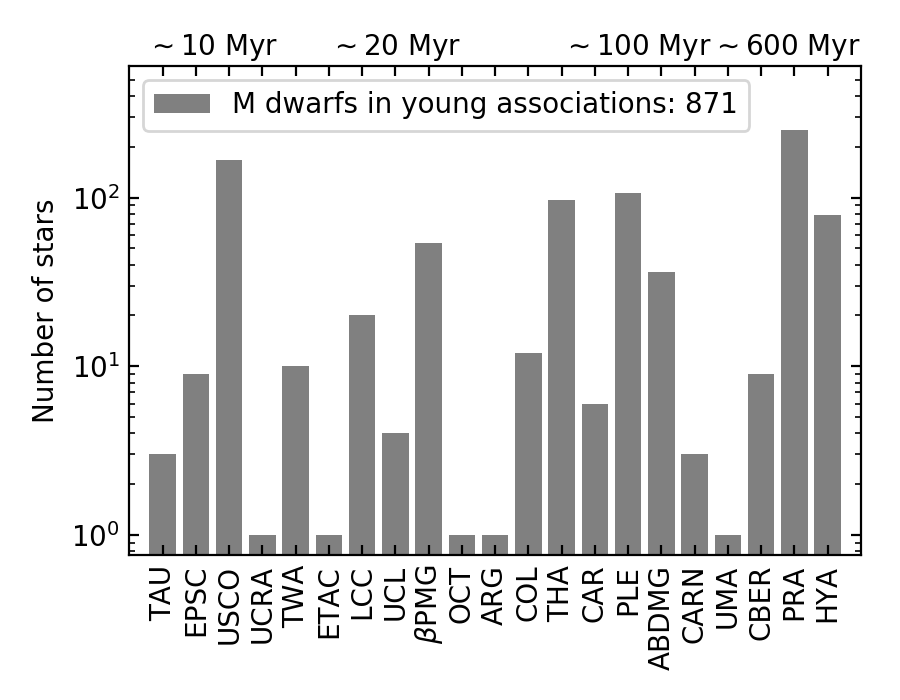

In [19]:
fs=10
plt.figure(figsize=(4.5,3.5))
#plt.bar(bins[:-1],y1,label='Total: {}'.format(n_tot),
#        color='#1c9099')

plt.bar(x_axis,y_compatible1,
        label='M dwarfs in young associations: {}'.format(sum(y_compatible1)),
        color='grey')
plt.xticks(x_axis, ['TAU', 'EPSC', 'USCO', 'UCRA', 'TWA', 'ETAC', 'LCC', 'UCL', r'$\beta$PMG',
       'OCT', 'ARG', 'COL', 'THA', 'CAR', 'PLE', 'ABDMG', 'CARN', 'UMA', 'CBER',
       'PRA', 'HYA'], rotation=90)#copy the list above
plt.yscale('log')
plt.xlim(-1,21)
plt.ylim(0,600)
plt.tick_params('both',direction='in',top=True,right=True)
plt.tick_params('y',which='minor',direction='in',right=True)
plt.text(-0.5,700,'$\sim 10$ Myr',fontsize=fs)
plt.text(5,700,'$\sim 20$ Myr',fontsize=fs)
plt.text(12,700,'$\sim 100$ Myr',fontsize=fs)
plt.text(16.5,700,'$\sim 600$ Myr',fontsize=fs)
plt.ylabel('Number of stars')
plt.legend(loc=2)
plt.tight_layout()
plt.savefig('/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/Mdwarfpergroup.png',
            dpi=300,tight_layout=True)
plt.show()

In [21]:
new_mem = Table.read('../data/new_members_data.csv',format='csv')#delimiter='\t')
#not_new_mem = Table.read('../data/not_a_new_member.csv',format='csv')
source_id_new_mem = new_mem['source_id']
#source_id_not_new_mem = not_new_mem['not_member']
mask_new_mem = np.array([x in source_id_new_mem for x in source_id])


In [22]:
banyan_stars = Table.read('../Catalogs/Sources/allmembers_banyan.fits')
mask_bf = (np.array([x.replace(' ','') == 'BF' or x.replace(' ','') == 'CM' for x in banyan_stars['col5']])) 
group_banyan_bf = np.array([x.replace(' ','') for x in banyan_stars['col4'][mask_bf]])
g_banyan_bf = np.array([float(x.replace('...','-1')) for x in banyan_stars['col138'][mask_bf]])
rp_banyan_bf = np.array([float(x.replace('...','-1')) for x in banyan_stars['col146'][mask_bf]])
g_rp_banyan_bf = g_banyan_bf - rp_banyan_bf
plx_banyan_bf = np.array([float(x.replace('...','-1')) for x in banyan_stars['col96'][mask_bf]])
g_abs_banyan_bf = g_banyan_bf - 5*(np.log10(1e3/plx_banyan_bf)-1)

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


In [23]:
mask_epsc = (group_name=='EPSC') * mask_new_mem
mask_usco = np.logical_or(np.logical_or(group_name=='USCO',group_name=='LCC'),group_name=='UCL') * mask_new_mem
mask_bpmg = np.logical_or(group_name=='BPMG',group_name=='THOR') * mask_new_mem
mask_abdmg = (group_name=='ABDMG') * mask_new_mem
masks_groups = [mask_epsc,mask_usco,mask_bpmg,mask_abdmg]
label_groups = ['EPSC','USCO\nLCC\nUCL',r'$\beta$PMG','ABDMG']
title_groups = [r'$\sim 3.7$Myr',r'$\sim 15$Myr',r'$\sim 20$Myr',r'$\sim 149$Myr']

mask_usco_banyan = np.logical_or(group_banyan_bf=='USCO',group_banyan_bf=='LCC',group_banyan_bf=='UCL') 
mask_bpmg_banyan = np.logical_or(group_banyan_bf=='BPMG',group_banyan_bf=='THOR')  
mask_abdmg_banyan = (group_banyan_bf=='ABDMG') 
mask_epsc_banyan = (group_banyan_bf=='EPSC') 
masks_groups_banyan = ([mask_epsc_banyan,mask_usco_banyan,mask_bpmg_banyan,mask_abdmg_banyan] 
                      * (~np.isnan(g_rp_banyan_bf+g_abs_banyan_bf)))

In [24]:
PLE_model = readsav('../Catalogs/Models/moving_groups/dr2_seq_fit_cf_PLE.sav')
BPMG_THOR_model = readsav('../Catalogs/Models/moving_groups/dr2_seq_fit_cf_BPMG_THOR.sav')
TWA_model = readsav('../Catalogs/Models/moving_groups/dr2_seq_fit_cf_TWA.sav')
USCO_model = readsav('../Catalogs/Models/moving_groups/dr2_seq_fit_cf_USCO_LCC_UCL.sav')

In [25]:
N = 30
x_ple = np.linspace(PLE_model['color_range'][0],PLE_model['color_range'][1],N)
y_ple = np.polyval(np.flipud(PLE_model['cf']),x_ple)

x_bpmg_thor = np.linspace(BPMG_THOR_model['color_range'][0],BPMG_THOR_model['color_range'][1],N)
y_bpmg_thor = np.polyval(np.flipud(BPMG_THOR_model['cf']),x_bpmg_thor)

x_twa = np.linspace(TWA_model['color_range'][0],TWA_model['color_range'][1],N)
y_twa = np.polyval(np.flipud(TWA_model['cf']),x_twa)

x_usco = np.linspace(USCO_model['color_range'][0],USCO_model['color_range'][1],N)
y_usco = np.polyval(np.flipud(USCO_model['cf']),x_usco)

p_epsc = np.polyfit(g_rp_banyan_bf[mask_epsc_banyan* (~np.isnan(g_rp_banyan_bf+g_abs_banyan_bf))],
                    g_abs_banyan_bf[mask_epsc_banyan* (~np.isnan(g_rp_banyan_bf+g_abs_banyan_bf))],3)
x_epsc = np.linspace(min(g_rp_banyan_bf[mask_epsc_banyan]),1.4)
y_epsc = np.ones(len(x_epsc))*-1

x_group = [x_epsc,x_usco,x_bpmg_thor,x_ple]
y_group = [y_epsc,y_usco,y_bpmg_thor,y_ple]

<IPython.core.display.Javascript object>


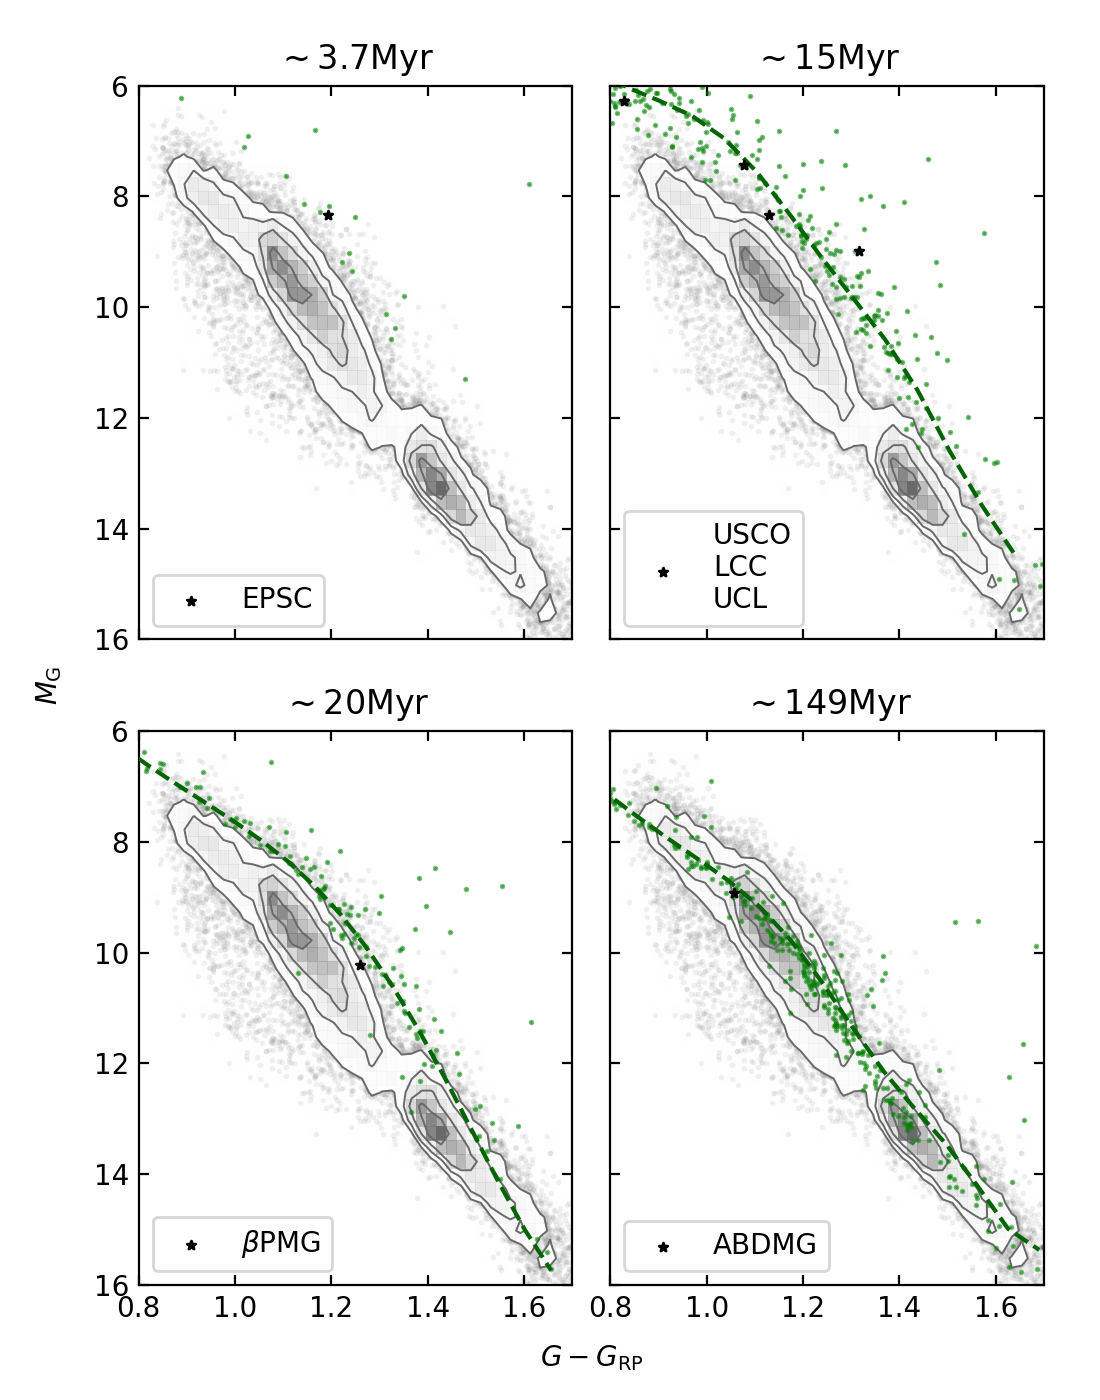

In [27]:
contour_color = 'dimgray'
s = 10
color = 'k'#'#ef8a62'
color_fit = 'g'
color_fit2 = 'darkgreen'
lw =1
loc=3

fig, axs = plt.subplots(2,2,sharex=True,sharey=True,figsize=(5.5,7))

axs = axs.ravel()

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

for i in range(4):
    hist2d(G_RP_ml, G_abs_ml,
           bins=50,plot_contours=True,plot_datapoints=True, color=contour_color,
           contour_kwargs={"linewidths":0.7},ax=axs[i],zorder=0)
    axs[i].scatter(g_rp_banyan_bf[masks_groups_banyan[i]],g_abs_banyan_bf[masks_groups_banyan[i]],
                   s=1,color=color_fit,alpha=0.5,zorder=2)
    axs[i].plot(x_group[i],y_group[i],'--',color=color_fit2,zorder=3)
    axs[i].scatter(g_rp[masks_groups[i]],g_abs[masks_groups[i]],marker='*',s=s,label=label_groups[i],
                   color=color,zorder=4)
    axs[i].tick_params('both',direction='in',top=True,right=True)
    axs[i].tick_params('y',which='minor',direction='in',right=True)
    axs[i].set_title(title_groups[i])
    axs[i].legend(loc=loc)

axs[0].set_ylim(16,6)
axs[0].set_xlim(0.8,1.7)

plt.tight_layout()
plt.xlabel(r'$G-G_{\rm RP}$')
plt.ylabel(r'$M_{\rm G}$')

plt.savefig('/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/ModelsGroups.png',
            dpi=300,tight_layout=True)

plt.show()

# Active Fraction

<IPython.core.display.Javascript object>


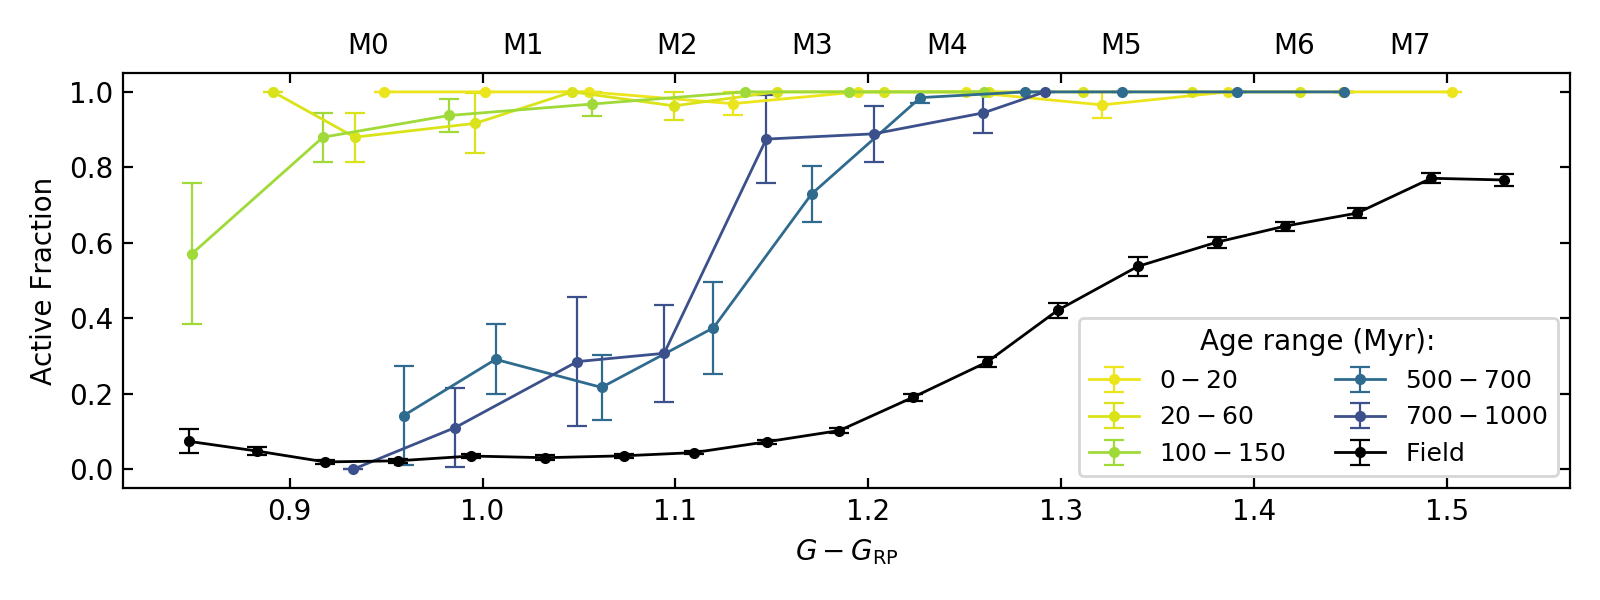

{'USCO', 'LCC', 'TWA', 'EPSC', 'UCL', 'TAU', 'ETAC', 'UCRA'}
[ 1.  7. 11. 13. 32. 21. 20. 29. 35. 34. 25.]
{'CAR', 'THA', 'BPMG', 'OCT', 'COL', 'ARG'}
[ 6. 25. 12. 10. 27. 23. 48. 54. 29. 19.  6. nan]
set()
[nan]
set()
[nan]
{'ABDMG', 'PLE'}
[ 7. 25. 32. 31. 41. 29.  8. nan nan nan]
{'CARN'}
[nan nan  2. nan]
set()
[nan]
{'UMA'}
[3.]
{'CBER', 'PRA'}
[ 7. 24. 23. 16. 37. 66. 61. 24. 19. 12.  3.]
{'HYA'}
[ 3.  8.  9.  7. 13.  8. 18. 18. 10.  2.]


/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less_equal


In [20]:
fractions = open('../data/activity_fraction.csv','a')
fractions.write('#age\tg-rp\tfraction\terror\n')
n_all = []
method1 = 'doane'
n_color = 8
min_color = 0.8
max_color = 1.55
color_range = np.linspace(min_color,max_color,n_color)
age_min = -20
age_max = 1000
age_bins = np.array([0,20,60,80,100,150,200,300,500,700,age_max])#np.linspace(age_min,age_max,10)
cmap = cm.viridis_r
norm = Normalize(vmin=age_min, vmax=age_max)

mask_ml = (~np.isnan(color_ml)) * (color_ml > min_color) * (color_ml < max_color)
color_bin_ml,active_fraction_ml,e_active_fraction_ml,ntot_ml  = src.calc_activity_fraction(color_ml[mask_ml],
                                                                                           ewha_ml[mask_ml],
                                                                                           method1)
y_text = 1.1
n = len(color_bin_ml)
lw = 1
elw = 0.8
f = plt.figure(figsize=(8,3))
cz=3.5

for i in range(len(age_bins)-1):
    mask_age1 = ((age > age_bins[i]) * (age <= age_bins[i+1]) * (~np.isnan(g_rp)) * (~np.isnan(ewha)) 
                 * (g_rp > min_color) * (g_rp < max_color))
    set_group_name = set(group_name[mask_age1])
    print(set_group_name)

    color_bin1,active_fraction1,e_active_fraction1,ntot1  = src.calc_activity_fraction(g_rp[mask_age1],
                                                                                       ewha[mask_age1],
                                                                                       method1)
    mask_ntot = ntot1 <= 4
    active_fraction1[mask_ntot] = np.nan
    
    print(ntot1)
    if(len(active_fraction1[~np.isnan(active_fraction1)])>n_color-4):
        for x in ntot1:
            n_all.append(x)
        plt.errorbar(color_bin1,active_fraction1,
                     yerr=e_active_fraction1,
                     label='${0:.0f} - {1:.0f}$'.format(age_bins[i],age_bins[i+1]),
                     color=cmap(norm(np.nanmean(age[mask_age1]))),
                     linewidth=lw,fmt='.-',elinewidth=elw,capsize=cz,capthick=elw)
        for x,y,z in zip(color_bin1,active_fraction1,e_active_fraction1):
            fractions.write(str(age_bins[i])+'-'+str(age_bins[i+1])+'\t'+str(x)+'\t'+str(y)+'\t'+str(z)+'\n')
plt.errorbar(color_bin_ml,active_fraction_ml,
             yerr=e_active_fraction_ml,
             fmt='.-',label='Field',color='k',
             linewidth=lw,elinewidth=elw,capsize=cz,capthick=elw)
for x,y,z in zip(color_bin_ml,active_fraction_ml,e_active_fraction_ml):
    fractions.write('field\t'+str(x)+'\t'+str(y)+'\t'+str(z)+'\n')
plt.text(0.93,y_text,'M0')
plt.text(1.01,y_text,'M1')
plt.text(1.09,y_text,'M2')
plt.text(1.16,y_text,'M3')
plt.text(1.23,y_text,'M4')
plt.text(1.32,y_text,'M5')
plt.text(1.41,y_text,'M6')
plt.text(1.47,y_text,'M7')
plt.legend(title='Age range (Myr):',loc=4,fontsize=9,ncol=2)#loc='center left', bbox_to_anchor=(1, 0.5), title='Age range:')
plt.tick_params('both',direction='in',top=True,right=True)
plt.tick_params('both',which='minor',direction='in',right=True)
plt.xlabel(r'$G-G_{\rm RP}$')
plt.ylabel('Active Fraction')
plt.tight_layout()
plt.savefig('/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/activefraction.pdf'
            ,tight_layout=True)
fractions.close()